In [5]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import warnings
warnings.filterwarnings("ignore",category = DeprecationWarning)
%matplotlib inline

%config Completer.use_jedi = False

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [15]:
combination = train.append(test,ignore_index=True)

In [7]:
combination.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is s...
1,2,0.0,@user @user thanks for #lyft credit i can't us...
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation


In [14]:
def delete_substr(string, substr):
    changes = re.findall(substr,string)
    for word in changes:
        string = re.sub(word,"",string)
    return string

In [20]:
combination["cleaned tweet"] = np.vectorize(delete_substr)(combination["tweet"], "@[\w]*")

In [22]:
combination["cleaned tweet"] = combination["cleaned tweet"].str.replace("[^a-zA-Z#]"," ",regex = True)

In [25]:
combination["cleaned tweet"] = combination["cleaned tweet"].apply(lambda tweet: " ".join([word for word in tweet.split() if len(word) >=4]))

In [26]:
combination.head()

,id,label,tweet,cleaned tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [27]:
tokenized = combination["cleaned tweet"].apply(lambda string: string.split()) 

In [28]:
tokenized.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: cleaned tweet, dtype: object

In [32]:
stemmer = nltk.PorterStemmer()
tokenized = tokenized.apply(lambda string: [stemmer.stem(word) for word in string])

In [33]:
tokenized.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, cau, they, offer, wheel...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: cleaned tweet, dtype: object

In [35]:
for i in range(0,len(tokenized)):
    tokenized[i] = " ".join(tokenized[i])
combination["cleaned tweet"] = tokenized

In [36]:
combination.head()


,id,label,tweet,cleaned tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit cau they offer wheelchair v...
2,3,0.0,bihday your majesty,bihday your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


In [38]:
def findhashtags(string):
    hashtags = []
    for word in string:
        hashtag = re.findall(r"#(\w+)", word)
        hashtags.append(hashtag)
    return hashtags

In [39]:
non_racist_hashtags = findhashtags(combination["cleaned tweet"][combination["label"] == 0])
racist_hashtags = findhashtags(combination["cleaned tweet"][combination["label"] == 1])

non_racist_hashtags = sum(non_racist_hashtags,[])
racist_hashtags = sum(racist_hashtags,[])

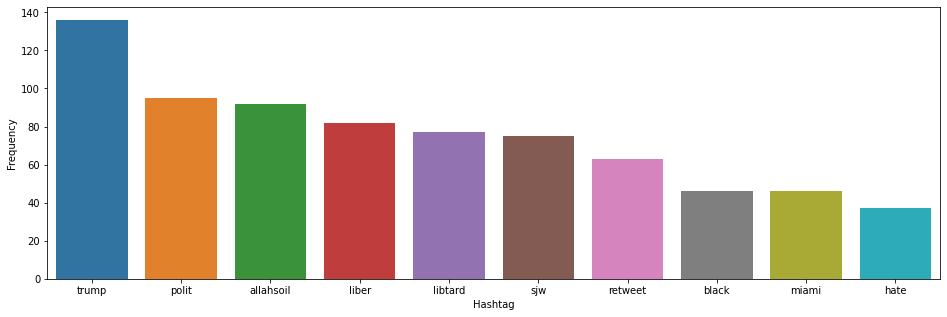

In [40]:
a = nltk.FreqDist(racist_hashtags)
d = pd.DataFrame(
    {
      'Hashtag': list(a.keys()),
     'Frequency': list(a.values())}
    )
d = d.nlargest(columns="Frequency", n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y="Frequency")
ax.set(ylabel = 'Frequency')
plt.show()

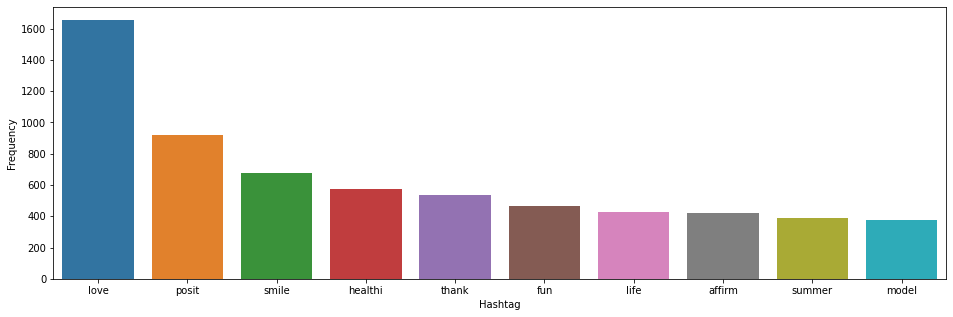

In [41]:
a = nltk.FreqDist(non_racist_hashtags)
d = pd.DataFrame(
    {
      'Hashtag': list(a.keys()),
     'Frequency': list(a.values())}
    )
d = d.nlargest(columns="Frequency", n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y="Frequency")
ax.set(ylabel = 'Frequency')
plt.show()

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
bowVectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words="english")
bow = bowVectorizer.fit_transform(combination['cleaned tweet'])

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtraining_data, xtesting_data, ytraining_data, ytesting_data = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtraining_data, ytraining_data) # training the model

prediction = lreg.predict_proba(xtesting_data) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.2 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)
f1_score(ytesting_data, prediction_int) # calculating f1 score


0.5464949928469242

In [51]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['tweet','label']]
submission.to_csv('logistic_regression_results.csv', index=False) # writing data to a CSV file